In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import time
import requests
from copy import deepcopy

def get_output(instance_tokens):
    debug = False
    if debug:
        print(0, instance_tokens)
    # Define the URL of the form endpoint
    url = 'http://127.0.0.1:5000'

    # Change the textarea (of name user_input) value to a custom text
    text = " ".join(instance_tokens)
    data = {
        'user_input': text
    }

    # Send the POST request
    response = requests.post(url, data=data)

    # get the p with the class "text-result"
    if len(response.text) == 0:
        return "Attention! No output was found."
    try:
        out = response.text.split('<p class="text-result">')[1].split('</p>')[0]
    except:
        print(response.text)
    # create list
    out = out.split('</span></span>')[:-1]
    d = {'tokens': [],
            'ner_tags': [],
            'confidence': []}
    for o in out:
        # find where highlight label- is and add the number after it to the dictionary
        d['ner_tags'].append(int(o.split('highlight label-')[1][0]))
        # find the text of the label
        text = o.split('">')[1].split('<span')[0]
        d['tokens'].append(text)
        if len(text) == 1:
            confidence = 100.0
        else:
            confidence = o[::-1][1:6][::-1]
            if confidence[0] =='>':
                confidence = confidence[1:]
            confidence = float(confidence)
        d['confidence'].append(confidence)

    if debug:
        print(1, d['tokens'])

    # map d, 0->'B-O', 1->'B-AC', 2->'B-LF', 3->'I-LF'  
    d['ner_tags'] = ['B-O' if x == 0 else 'B-AC' if x == 1 else 'B-LF' if x == 2 else 'I-LF' if x == 3 else 'ERROR' for x in d['ner_tags']]

    # go through the tokens and if there is a space in the token, divide it into multiple tokens and add the same label and confidence

    out = {'tokens': [], 'ner_tags': [], 'confidence': []}
    for i in range(len(d['tokens'])):
        if ' ' in d['tokens'][i]:
            # split the token into multiple tokens
            tokens = d['tokens'][i].split(' ')
            for j in range(len(tokens)):
                out['tokens'].append(tokens[j])
                out['ner_tags'].append(d['ner_tags'][i])
                out['confidence'].append(d['confidence'][i])
        else:
            out['tokens'].append(d['tokens'][i])
            out['ner_tags'].append(d['ner_tags'][i])
            out['confidence'].append(d['confidence'][i])

    if debug:
        print(2, out['tokens'])

    tokens_to_merge = find_tokens_to_merge(out['tokens'], instance_tokens)         

    new_out = deepcopy(out)

    # Merge the tokens
    to_remove = []
    for merge_list in tokens_to_merge:
        # Merge the tokens
        merged_token = ''.join([out['tokens'][i] for i in merge_list])
        out['tokens'][merge_list[0]] = merged_token
        to_remove.append(merge_list[1:])
        # Merge the NER tags
        out['ner_tags'][merge_list[0]] = out['ner_tags'][merge_list[0]]
        # Merge the confidence
        out['confidence'][merge_list[0]] = out['confidence'][merge_list[0]]

    # flatten to_remove
    to_remove = [item for sublist in to_remove for item in sublist]

    # remove the tokens that were merged
    new_out['tokens'] = [i for j, i in enumerate(out['tokens']) if j not in to_remove]
    new_out['ner_tags'] = [i for j, i in enumerate(out['ner_tags']) if j not in to_remove]
    new_out['confidence'] = [i for j, i in enumerate(out['confidence']) if j not in to_remove]
    out = new_out

    if debug:
        print(3, out['tokens'])

    return(out)

def find_tokens_to_merge(mine, theirs):
    # Initialize indices and result list
    mine_index = 0
    theirs_index = 0
    merged_indices = []

    # Traverse through 'theirs' list to find corresponding tokens in 'mine'
    while theirs_index < len(theirs):
        # Start merging tokens from 'mine' to match the current 'theirs' token
        temp_token = ''
        merge_list = []
        while mine_index < len(mine) and temp_token != theirs[theirs_index]:
            temp_token += mine[mine_index]
            merge_list.append(mine_index)
            mine_index += 1

        # Check if the tokens merged correctly
        if temp_token == theirs[theirs_index]:
            if len(merge_list) > 1:
                merged_indices.append(merge_list)
            theirs_index += 1
        else:
            print("Mine:", mine)
            print("Theirs:", theirs)
            raise ValueError(f"Cannot merge tokens to match '{theirs[theirs_index]}' from '{mine}'")

    return merged_indices

In [2]:
get_output(['I', 'want', 'to', 'see', 'you', 'ASAP', '(', 'as', 'soon', 'as', 'possible', ')', '.'])

{'tokens': ['I',
  'want',
  'to',
  'see',
  'you',
  'ASAP',
  '(',
  'as',
  'soon',
  'as',
  'possible',
  ')',
  '.'],
 'ner_tags': ['B-O',
  'B-O',
  'B-O',
  'B-O',
  'B-O',
  'B-AC',
  'B-O',
  'B-O',
  'B-O',
  'B-O',
  'B-O',
  'B-O',
  'B-O'],
 'confidence': [100.0,
  99.99,
  99.99,
  99.99,
  99.99,
  99.98,
  100.0,
  99.99,
  99.99,
  99.99,
  99.99,
  100.0,
  100.0]}

In [3]:
from datasets import load_dataset

dataset = load_dataset("surrey-nlp/PLOD-CW")

/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
test_dataset = dataset['test']

In [5]:
get_output(test_dataset[0]['tokens'])

{'tokens': ['Abbreviations',
  ':',
  'GEMS',
  ',',
  'Global',
  'Enteric',
  'Multicenter',
  'Study',
  ';',
  'VIP',
  ',',
  'ventilated',
  'improved',
  'pit',
  '.'],
 'ner_tags': ['B-O',
  'B-O',
  'B-AC',
  'B-O',
  'B-LF',
  'I-LF',
  'I-LF',
  'I-LF',
  'B-O',
  'B-AC',
  'B-O',
  'B-LF',
  'I-LF',
  'I-LF',
  'B-O'],
 'confidence': [99.99,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  99.99,
  95.87,
  100.0]}

In [6]:
def compare(test_dataset):
    pred, true = [], []
    for i, instance in enumerate(test_dataset):
        pred.append(get_output(instance['tokens'])['ner_tags'])
        true.append(instance['ner_tags'])
        if len(pred[-1]) != len(true[-1]):
            print("---- Error -----")
            print(instance['tokens'])
            print(get_output(instance['tokens'])['tokens'])
            break
        if i % 20 == 0:
            print(f"Processed {i} sentences out of {len(test_dataset)}")
    # flatten the lists
    pred = [item for sublist in pred for item in sublist]
    true = [item for sublist in true for item in sublist]
    return pred, true

In [7]:
pred, true = compare(test_dataset)

Processed 0 sentences out of 153
Processed 20 sentences out of 153
Processed 40 sentences out of 153
Processed 60 sentences out of 153
Processed 80 sentences out of 153
Processed 100 sentences out of 153
Processed 120 sentences out of 153
Processed 140 sentences out of 153


In [8]:
len(pred), len(true)

(5000, 5000)

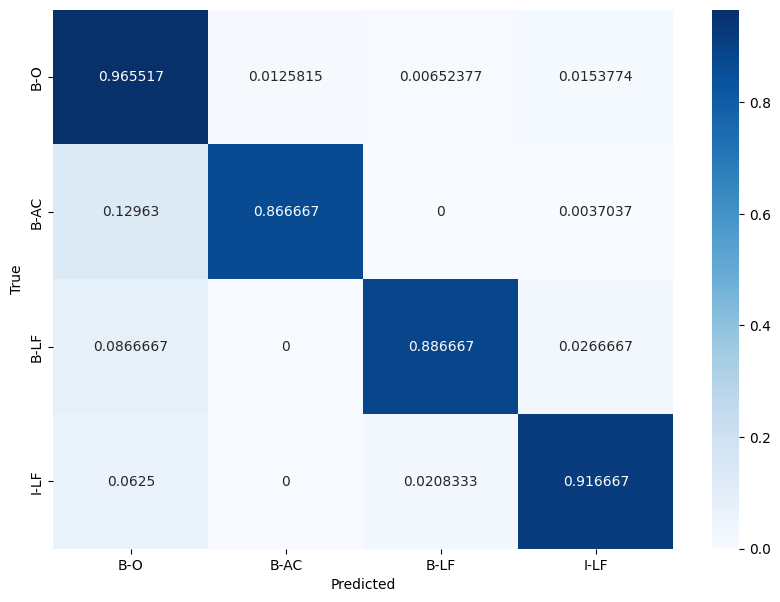

In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true, pred, labels=['B-O', 'B-AC', 'B-LF', 'I-LF'], normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['B-O', 'B-AC', 'B-LF', 'I-LF'], yticklabels=['B-O', 'B-AC', 'B-LF', 'I-LF'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()